<a href="https://colab.research.google.com/github/MigXDev/CS_Datos_I_DESAFIO_3/blob/main/TelecomX_LATAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challengue Alura - TelecomX

## 1. Importacion de Bibliotecas 📂

In [70]:
# Importación de librerías esenciales
import pandas as pd # Manipulación de datos
import numpy as np # Manipulación de datos

import matplotlib.pyplot as plt # Visualización de Datos
import seaborn as sns # Visualización de Datos

# Para preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# Modelos que se utilizarán más adelante
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# Advertencias (para limpiar outputs si es necesario)
import warnings
warnings.filterwarnings("ignore")

## 2. Preparación de los Datos 🛠️



### Extracción del Archivo Tratado - **INSTRUCCIONES**

Carga el archivo `.csv` que contiene los datos tratados anteriormente.<br>

>📂 **Atención:** <br>Utiliza el mismo archivo que limpiaste y organizaste en la Parte 1 del desafío Telecom X. Debe contener solo las columnas relevantes, ya con los datos corregidos y estandarizados.

<br>
<hr>

### 2.1. **Carga y exploración del dataset**

Comenzamos cargando la base de datos ya tratada. Se trata de un dataset de clientes de una empresa de telecomunicaciones. El objetivo será predecir si un cliente abandonará el servicio (`abandono_cliente`) en base a sus características.

A continuación se realiza una primera inspección.


In [71]:
Datos = '/content/TelecomX_Data_Base.csv'

In [72]:
# Cargamos el archivo CSV procesado
Df = pd.read_csv('/content/TelecomX_Data_Base.csv', sep=';')

Df_base = Df.copy()

# Visualizamos las primera fila
Df_base.head(1)

,id_cliente,abandono_cliente,genero,jubilado,pareja,dependientes,meses_antiguedad,servicio_telefono,ad.multiples_lineas,servicio_internet,...,ad.proteccion_dispositivo,ad.soporte_tecnico,tv.streaming,peliculas.streaming,contrato,factura_digital,metodo_pago,cargo.diario,cargo.mensual,cargo.total
0,0002-ORFBO,No,Femenino,False,Si,Si,9,Si,No,DSL,...,No,Si,Si,No,Un año,Si,Cheque por correo,2.16,65.6,593.3


### **2.2. Inspección estructural**

In [73]:
# Exploramos descripción estadística de variables numéricas
Df_base.describe()

,meses_antiguedad,cargo.diario,cargo.mensual,cargo.total
count,7267.000000,7267.000000,7267.000000,7267.000000
mean,32.346498,2.127771,64.720098,2277.182035
std,24.571773,0.990534,30.129572,2268.648587
min,0.000000,0.600000,18.250000,0.000000
25%,9.000000,1.165000,35.425000,396.200000
50%,29.000000,2.310000,70.300000,1389.200000
75%,55.000000,2.955000,89.875000,3778.525000
max,72.000000,3.900000,118.750000,8684.800000


In [74]:
# Exploración básica
print(f"Filas: {Df_base.shape[0]}, Columnas: {Df_base.shape[1]}")
print(f"\nTipos de datos:\n{Df_base.dtypes.value_counts()}")

# Busca valores nulos
if Df_base.isnull().any().sum() == 0:
    print("\nNo hay columnas con valores nulos")
else:
    print("\nColumnas con valores nulos:")
    for col in Df_base.columns:
        if Df_base[col].isnull().any():
            print(f"{col}: {Df_base[col].isnull().sum()} valores nulos")

Filas: 7267, Columnas: 22

Tipos de datos:
object     17
float64     3
bool        1
int64       1
Name: count, dtype: int64

No hay columnas con valores nulos


### Verificación de la Proporción de Cancelación (Churn) - **INSTRUCCIONES**

Calcula la proporción de clientes que cancelaron en relación con los que permanecieron activos. Evalúa si existe un desbalance entre las clases, ya que esto puede impactar en los modelos predictivos y en el análisis de los resultados.

>🔎 **Sugerencia:**<br>
Puedes usar `value_counts()` de pandas para obtener esta proporción:
[Documentación oficial de ](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html "‌")`value_counts()`

<br>
<hr>

### 2.3.

In [ ]:
print("Proporcion Cantidad:",Df_base['abandono_cliente'].value_counts())
print("Proporcion porcentaje:", Df_base['abandono_cliente'].value_counts(normalize=True).round(3)*100)

Proporcion Cantidad: abandono_cliente
No    5339
Si    1928
Name: count, dtype: int64
Proporcion porcentaje: abandono_cliente
No    73.5
Si    26.5
Name: proportion, dtype: float64


### 2.4.

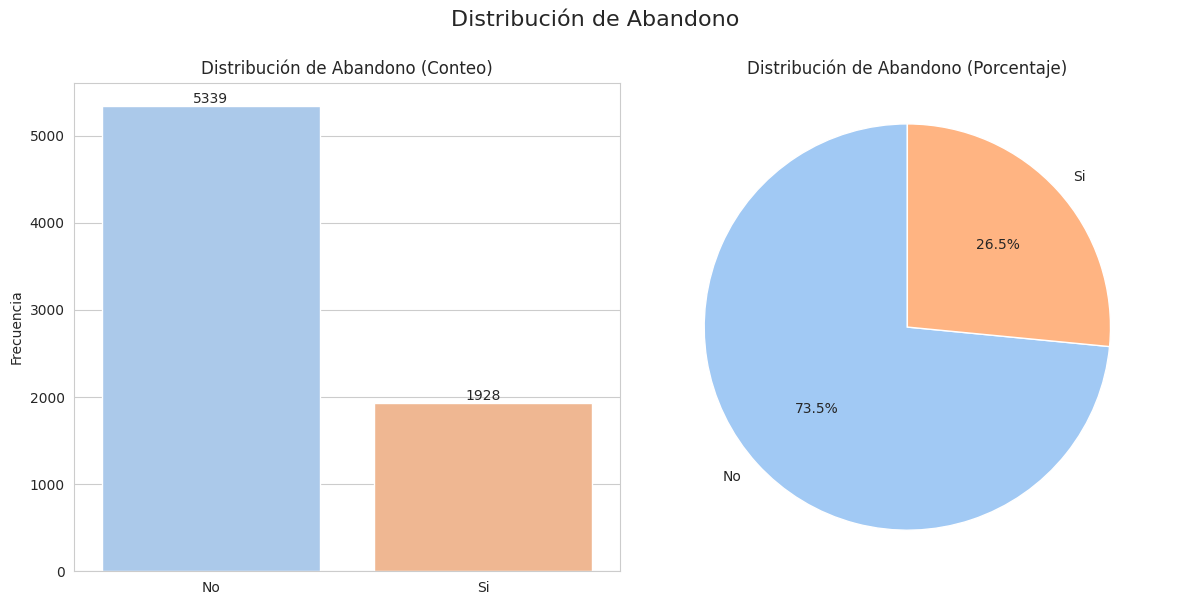

In [111]:
# Grafico de barras y grafico de torta de la distribucion general de 'abandono_cliente'

# Calcular la distribución de 'abandono_cliente'
churn_counts = Df_base['abandono_cliente'].value_counts() # Cuenta la frecuencia de cada valor en la columna 'abandono_cliente'
churn_proportions = Df_base['abandono_cliente'].value_counts(normalize=True) * 100 # Calcula la proporción de cada valor y la convierte a porcentaje

# Configurar el estilo del gráfico
sns.set_style("whitegrid") # Establece un estilo de cuadrícula blanca para los gráficos

# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Crea una figura y un conjunto de subplots (1 fila, 2 columnas) con un tamaño específico

fig.suptitle('Distribución de Abandono', fontsize=16, y=1) # Añade un título principal a la figura

# --- Bar Chart ---
ax1 = axes[0] # Selecciona el primer subplot para el gráfico de barras
sns.countplot(x='abandono_cliente', data=Df_base, ax=ax1, palette=sns.color_palette("pastel")) # Utiliza una paleta de colores pastel) # Crea un gráfico de barras de la columna 'abandono_cliente'
ax1.set_title('Distribución de Abandono (Conteo)') # Establece el título del primer subplot
ax1.set_xlabel('') # Establece la etiqueta del eje x
ax1.set_ylabel('Frecuencia') # Establece la etiqueta del eje y

# Add exact counts on the bars
for container in ax1.containers: # Itera sobre los contenedores de barras en el gráfico
    ax1.bar_label(container) # Añade etiquetas a cada barra con su valor

# --- Pie Chart ---
ax2 = axes[1] # Selecciona el segundo subplot para el gráfico de torta
ax2.pie(
    churn_counts, # Datos para el gráfico de torta (conteo de valores)
    labels=churn_counts.index, # Etiquetas para cada sector del gráfico de torta
    autopct='%1.1f%%', # Formato para mostrar los porcentajes en el gráfico de torta (un decimal)
    startangle=90, # Ángulo de inicio para el primer sector
    colors=sns.color_palette('pastel')[0:len(churn_counts)] # Utiliza una paleta de colores pastel
)
ax2.set_title('Distribución de Abandono (Porcentaje)') # Establece el título del segundo subplot
ax2.axis('equal') # Asegura que el gráfico de torta sea un círculo

plt.tight_layout() # Ajusta automáticamente los parámetros de la subtrama para que encajen en el área de la figura.
plt.show() # Muestra los gráficos

### **2.3. Análisis Univariado (EDA)**

#### **2.3.1. Analisis numerico**

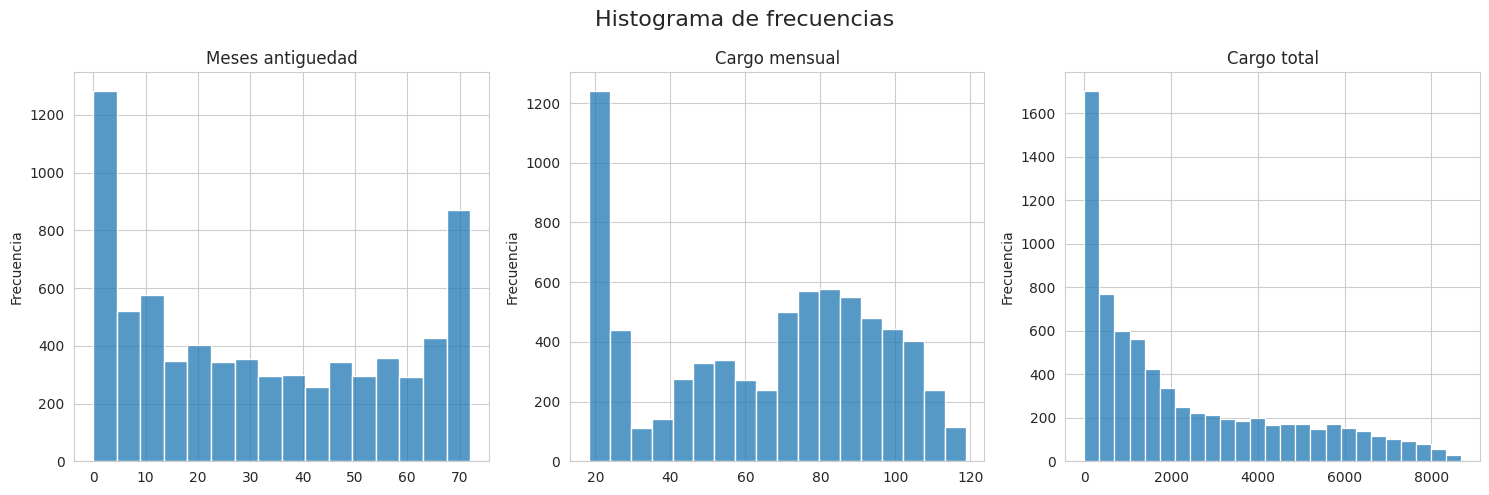

In [77]:
# Histograma de frecuencias utilizando las categorias numericas 'meses_antiguedad', 'Cargo.mensual', "Cargo.total"
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Histograma de frecuencias", fontsize=16)
sns.histplot(data=Df_base, x="meses_antiguedad", ax=ax[0])
sns.histplot(data=Df_base, x="cargo.mensual", ax=ax[1])
sns.histplot(data=Df_base, x="cargo.total", ax=ax[2])
ax[0].set_title("Meses antiguedad")
ax[1].set_title("Cargo mensual")
ax[2].set_title("Cargo total")

for i in range(3):
    ax[i].set_ylabel("Frecuencia")
    ax[i].set_xlabel("")

plt.tight_layout()
plt.show()

#### **2.3.2. Analisis categorico**

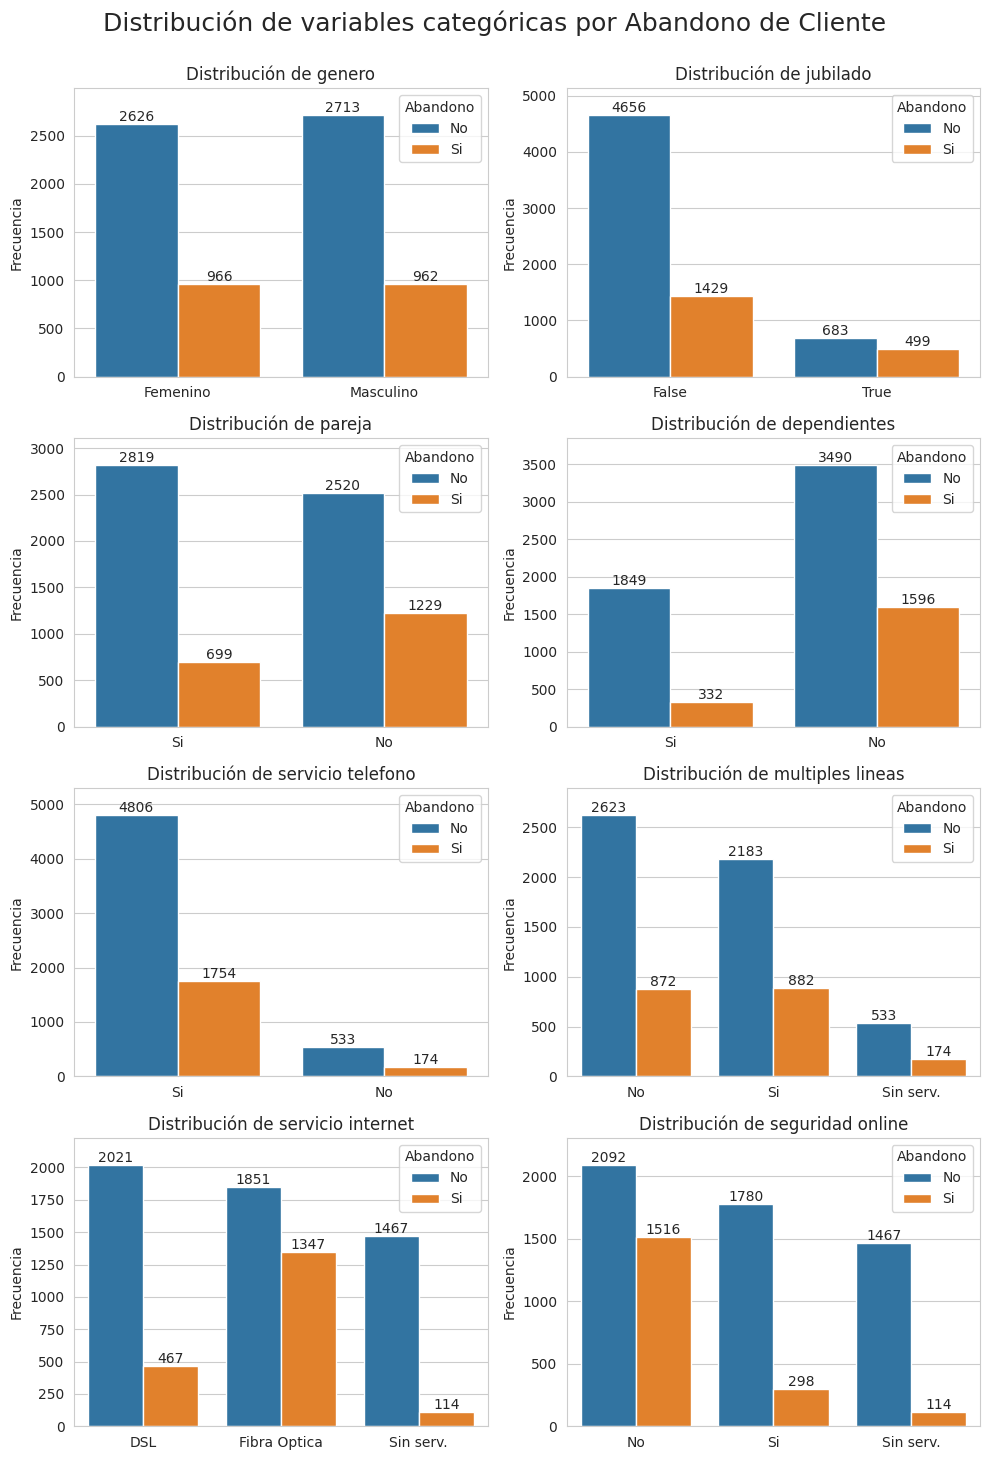

In [79]:
# Columnas
cols = ['genero', 'jubilado', 'pareja', 'dependientes', 'servicio_telefono', 'ad.multiples_lineas', 'servicio_internet', 'ad.seguridad_online']
col_nomb = ['genero', 'jubilado', 'pareja', 'dependientes', 'servicio telefono', 'multiples lineas', 'servicio internet', 'seguridad online']

fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()
fig.suptitle("Distribución de variables categóricas por Abandono de Cliente", fontsize=18, y=1)
for i, col in enumerate(cols):
    ax = axes[i] # Get the current axis
    sns.countplot(x=col, hue='abandono_cliente', data=Df_base, ax=ax)
    ax.set_title(f'Distribución de {col_nomb[i]}')
    ax.set_xlabel('')
    ax.set_ylabel('Frecuencia')
    ax.legend(title='Abandono', loc='upper right')

    for container in ax.containers:
        ax.bar_label(container)

    if col == 'ad.multiples_lineas':
        ax.set_xticklabels(['No', 'Si', 'Sin serv.'])
    if col == 'ad.seguridad_online':
        ax.set_xticklabels(['No', 'Si', 'Sin serv.'])
    if col == 'servicio_internet':
        ax.set_xticklabels(['DSL', 'Fibra Optica', 'Sin serv.'])

    # Añade espacio a los valores numericos para que no se corten
    y_max = ax.get_ylim()[1]
    ax.set_ylim(0, y_max * 1.05)

#Mod            [Izq, Abajo, Der, Arriba]
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

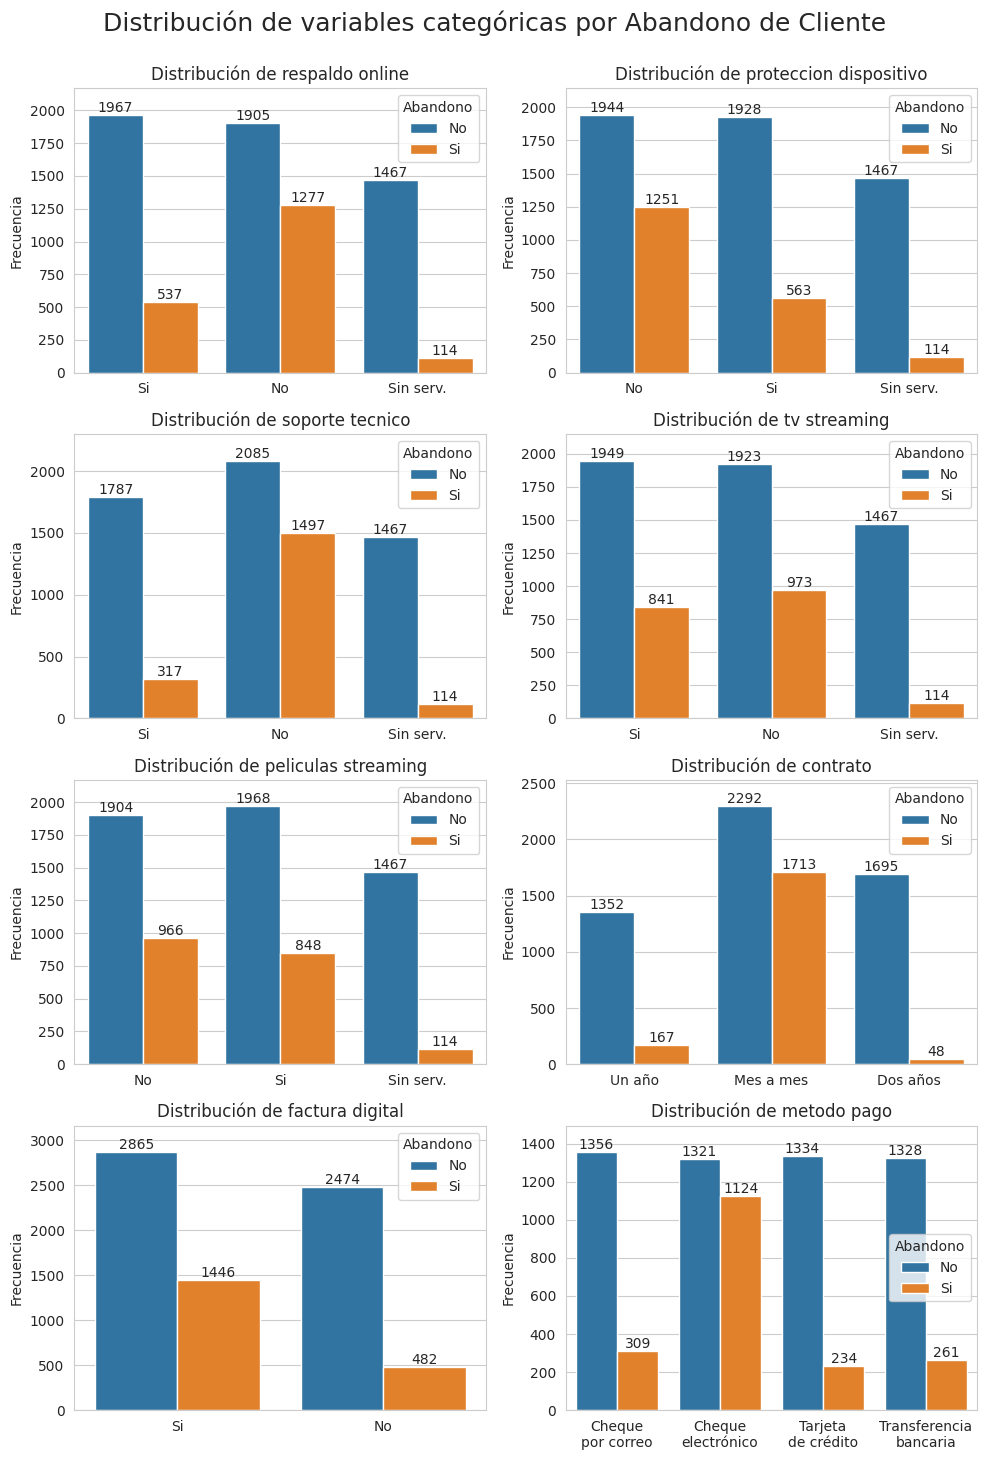

In [86]:
# Columnas
cols = ['ad.respaldo_online', 'ad.proteccion_dispositivo', 'ad.soporte_tecnico',
'tv.streaming', 'peliculas.streaming', 'contrato', 'factura_digital', 'metodo_pago']
col_nomb = ['respaldo online', 'proteccion dispositivo', 'soporte tecnico',
'tv streaming', 'peliculas streaming', 'contrato', 'factura digital', 'metodo pago']

fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()
fig.suptitle("Distribución de variables categóricas por Abandono de Cliente", fontsize=18, y=1)
for i, col in enumerate(cols):
    ax = axes[i]
    sns.countplot(x=col, hue='abandono_cliente', data=Df_base, ax=ax)
    ax.set_title(f'Distribución de {col_nomb[i]}')
    ax.set_xlabel('')
    ax.set_ylabel('Frecuencia')
    ax.legend(title='Abandono', loc='best')

    for container in ax.containers:
        ax.bar_label(container)

    if col == 'ad.respaldo_online':
        ax.set_xticklabels(['Si', 'No', 'Sin serv.'])
    if col == 'ad.proteccion_dispositivo':
        ax.set_xticklabels(['No', 'Si', 'Sin serv.'])
    if col == 'ad.soporte_tecnico':
        ax.set_xticklabels(['Si', 'No', 'Sin serv.'])
    if col == 'tv.streaming':
        ax.set_xticklabels(['Si', 'No', 'Sin serv.'])
    if col == 'peliculas.streaming':
        ax.set_xticklabels(['No', 'Si', 'Sin serv.'])
    if col == 'metodo_pago':
        ax.set_xticklabels(['Cheque\npor correo', 'Cheque\nelectrónico', 'Tarjeta\nde crédito', 'Transferencia\nbancaria'])

    # Añade espacio a los valores numericos para que no se corten
    y_max = ax.get_ylim()[1]
    ax.set_ylim(0, y_max * 1.05)

#Mod            [Izq, Abajo, Der, Arriba]
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

### **2. Eliminación de Columnas Irrelevantes**

Elimina columnas que **no aportan valor al análisis** o a **los modelos predictivos**, como identificadores únicos (por ejemplo, el ID del cliente). Estas columnas no ayudan en la predicción de la cancelación y pueden incluso perjudicar el desempeño de los modelos.

In [ ]:
Df_base.drop(columns=['id_cliente', 'cargo.diario'], axis=1,inplace=True)

**Eliminar columnas redundantes o problemáticas**

*   `id_cliente`: Identificador único sin valor predictivo.
*   `cargo.diario`: **Redundante**. Se calcula como `cargo.mensual / 30` (aproximado). No añade información única.



In [ ]:
# Conversión de target
Df_base['abandono_cliente'] = Df_base['abandono_cliente'].map({'Si': 1, 'No': 0})

`abandono_cliente`:

*   Si: `1`
*   No: `0`




In [ ]:
# === Etapa 1: Agrupar "Sin servicio telefónico" como "No"
# Identify object columns
object_cols = Df_base.select_dtypes(include='object').columns

for col in object_cols:
    Df_base[col] = Df_base[col].replace('Sin servicio de internet', 'No')

Df_base["ad.multiples_lineas"] = Df_base["ad.multiples_lineas"].replace('Sin servicio telefónico', 'No')

In [ ]:
Df_base.tail(1)

,abandono_cliente,genero,jubilado,pareja,dependientes,meses_antiguedad,servicio_telefono,ad.multiples_lineas,servicio_internet,ad.seguridad_online,ad.respaldo_online,ad.proteccion_dispositivo,ad.soporte_tecnico,tv.streaming,peliculas.streaming,contrato,factura_digital,metodo_pago,cargo.mensual,cargo.total
7266,0,Masculino,False,Si,Si,63,No,No,DSL,Si,Si,Si,No,Si,Si,Dos años,No,Cheque electrónico,59.0,3707.6


In [ ]:
Df_base.columns

Index(['abandono_cliente', 'genero', 'jubilado', 'pareja', 'dependientes',
       'meses_antiguedad', 'servicio_telefono', 'ad.multiples_lineas',
       'servicio_internet', 'ad.seguridad_online', 'ad.respaldo_online',
       'ad.proteccion_dispositivo', 'ad.soporte_tecnico', 'tv.streaming',
       'peliculas.streaming', 'contrato', 'factura_digital', 'metodo_pago',
       'cargo.mensual', 'cargo.total'],
      dtype='object')

### **2. División Train/Test (con variables categóricas)**

*   `X` se usa para modelos no lineales (árboles, random forest, etc.)
*   `X_linear` se usa para modelos lineales (regresión logística, etc.) que requieren evitar multicolinealidad.

Selección de features (X) y target (y):

In [ ]:
# Dividir ANTES de transformaciones para evitar data leakage
X = Df_base.drop(columns=['abandono_cliente'], axis=1)
y = Df_base['abandono_cliente']

In [ ]:
# Dividir datos en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,  # Mantener proporción de clases
    random_state=42
)

In [ ]:
# Confirmás que los índices se mantienen
print(X.index.is_monotonic_increasing)  # True
print(X_train.index[:5])  # índices salteados, pero del original
print(X_test.index[:5])   # igual

True
Index([6511, 5257, 6357, 5137, 5848], dtype='int64')
Index([6988, 156, 544, 6495, 2258], dtype='int64')


In [ ]:
# Identificar tipos de columnas
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

**Explicación de manejo de categóricas:**<br>
La división se hace con las variables categóricas originales porque:
1.   No introduce data leakage
2.   `train_test_split` puede manejar objetos/strings sin problemas
3.   Las transformaciones se aplicarán después solo al training set

Hace lo mismo solo que mas automatizado

```
  Categorias = ['genero', 'jubilado', 'pareja', 'dependientes', 'servicio_telefono',
                'ad.multiples_lineas', 'servicio_internet', 'ad.seguridad_online',
                'ad.respaldo_online', 'ad.proteccion_dispositivo', 'ad.soporte_tecnico',
                'tv.streaming', 'peliculas.streaming', 'contrato', 'factura_digital', 'metodo_pago',]
```

### **2. Encoding**

Transforma las variables categóricas a formato numérico para hacerlas compatibles con los algoritmos de _machine learning_. Utiliza un método de codificación adecuado, como **one-hot encoding**.

Transformadores (`make_column_transformer`)

In [ ]:
label_encoder = LabelEncoder()

# Creamos un transformador para preparar las columnas
preprocesador_one_hot = make_column_transformer(
    # A las columnas categóricas les aplicamos One-Hot Encoding (sin la primera para evitar errores)
    (OneHotEncoder(drop='first'), categorical_cols),
    # El resto de las columnas pasa sin cambios (numéricas u otras)
    remainder='passthrough',
    # Convertimos todo el resultado en una tabla normal (no comprimida)
    sparse_threshold=0,
    # No forzamos los tipos de las otras columnas (las dejamos como están)
    force_int_remainder_cols=False
)

Aplicar los transformadores:

In [ ]:
# Aplicar solo al training set
#Entrena y
X_train_processed = preprocesador_one_hot.fit_transform(X_train)
X_test_processed = preprocesador_one_hot.transform(X_test)

y = label_encoder.fit_transform(y)

In [ ]:
X_test_processed

array([[1.00000e+00, 0.00000e+00, 1.00000e+00, ..., 6.80000e+01,
        1.03250e+02, 7.07440e+03],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 7.20000e+01,
        1.09900e+02, 7.62420e+03],
       [1.00000e+00, 0.00000e+00, 1.00000e+00, ..., 1.10000e+01,
        6.51500e+01, 7.23350e+02],
       ...,
       [1.00000e+00, 0.00000e+00, 1.00000e+00, ..., 2.80000e+01,
        9.29000e+01, 2.76835e+03],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 4.10000e+01,
        8.05500e+01, 3.26390e+03],
       [1.00000e+00, 0.00000e+00, 1.00000e+00, ..., 7.20000e+01,
        1.93000e+01, 1.30480e+03]])

Obtener nombres de columnas codificadas:

In [ ]:
columnas = preprocesador_one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

#### Transformacion a Df

In [ ]:
Df_Train = pd.DataFrame(X_train_processed, columns=columnas_encoded, index=X_train.index)

Df_Test = pd.DataFrame(X_test_processed, columns=columnas_encoded, index=X_test.index)

Df_EncodedTT = pd.concat([Df_Train, Df_Test])
Df_EncodedTT = Df_EncodedTT.sort_index()

Df_EncodedTT.tail(1)

,genero_Masculino,jubilado_True,pareja_Si,dependientes_Si,servicio_telefono_Si,ad.multiples_lineas_Si,servicio_internet_Fibra óptica,servicio_internet_No,ad.seguridad_online_Si,ad.respaldo_online_Si,...,peliculas.streaming_Si,contrato_Mes a mes,contrato_Un año,factura_digital_Si,metodo_pago_Cheque por correo,metodo_pago_Tarjeta de crédito (automática),metodo_pago_Transferencia bancaria (automática),meses_antiguedad,cargo.mensual,cargo.total
7266,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,59.0,3707.6


Creacion de Df_No_lineal

In [ ]:
Df_encod_y = pd.DataFrame(y, columns=['abandono_cliente_si'])
Df_Encoded = pd.concat([Df_EncodedTT, Df_encod_y], axis=1)
Df_Encoded

,genero_Masculino,jubilado_True,pareja_Si,dependientes_Si,servicio_telefono_Si,ad.multiples_lineas_Si,servicio_internet_Fibra óptica,servicio_internet_No,ad.seguridad_online_Si,ad.respaldo_online_Si,...,contrato_Mes a mes,contrato_Un año,factura_digital_Si,metodo_pago_Cheque por correo,metodo_pago_Tarjeta de crédito (automática),metodo_pago_Transferencia bancaria (automática),meses_antiguedad,cargo.mensual,cargo.total,abandono_cliente_si
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,9.0,65.60,593.30,0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,9.0,59.90,542.40,0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,4.0,73.90,280.85,1
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,13.0,98.00,1237.85,1
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,3.0,83.90,267.40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,13.0,55.15,742.90,0
7263,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,22.0,85.10,1873.70,1
7264,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,2.0,50.30,92.75,0
7265,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,67.0,67.85,4627.65,0


### Análisis de Correlación

Visualiza la matriz de correlación para identificar relaciones entre las variables numéricas. Presta especial **atención a las variables que muestran una mayor correlación con la cancelación**, ya que estas pueden ser fuertes candidatas para el modelo predictivo.

In [ ]:
corr = Df_Encoded.corr()

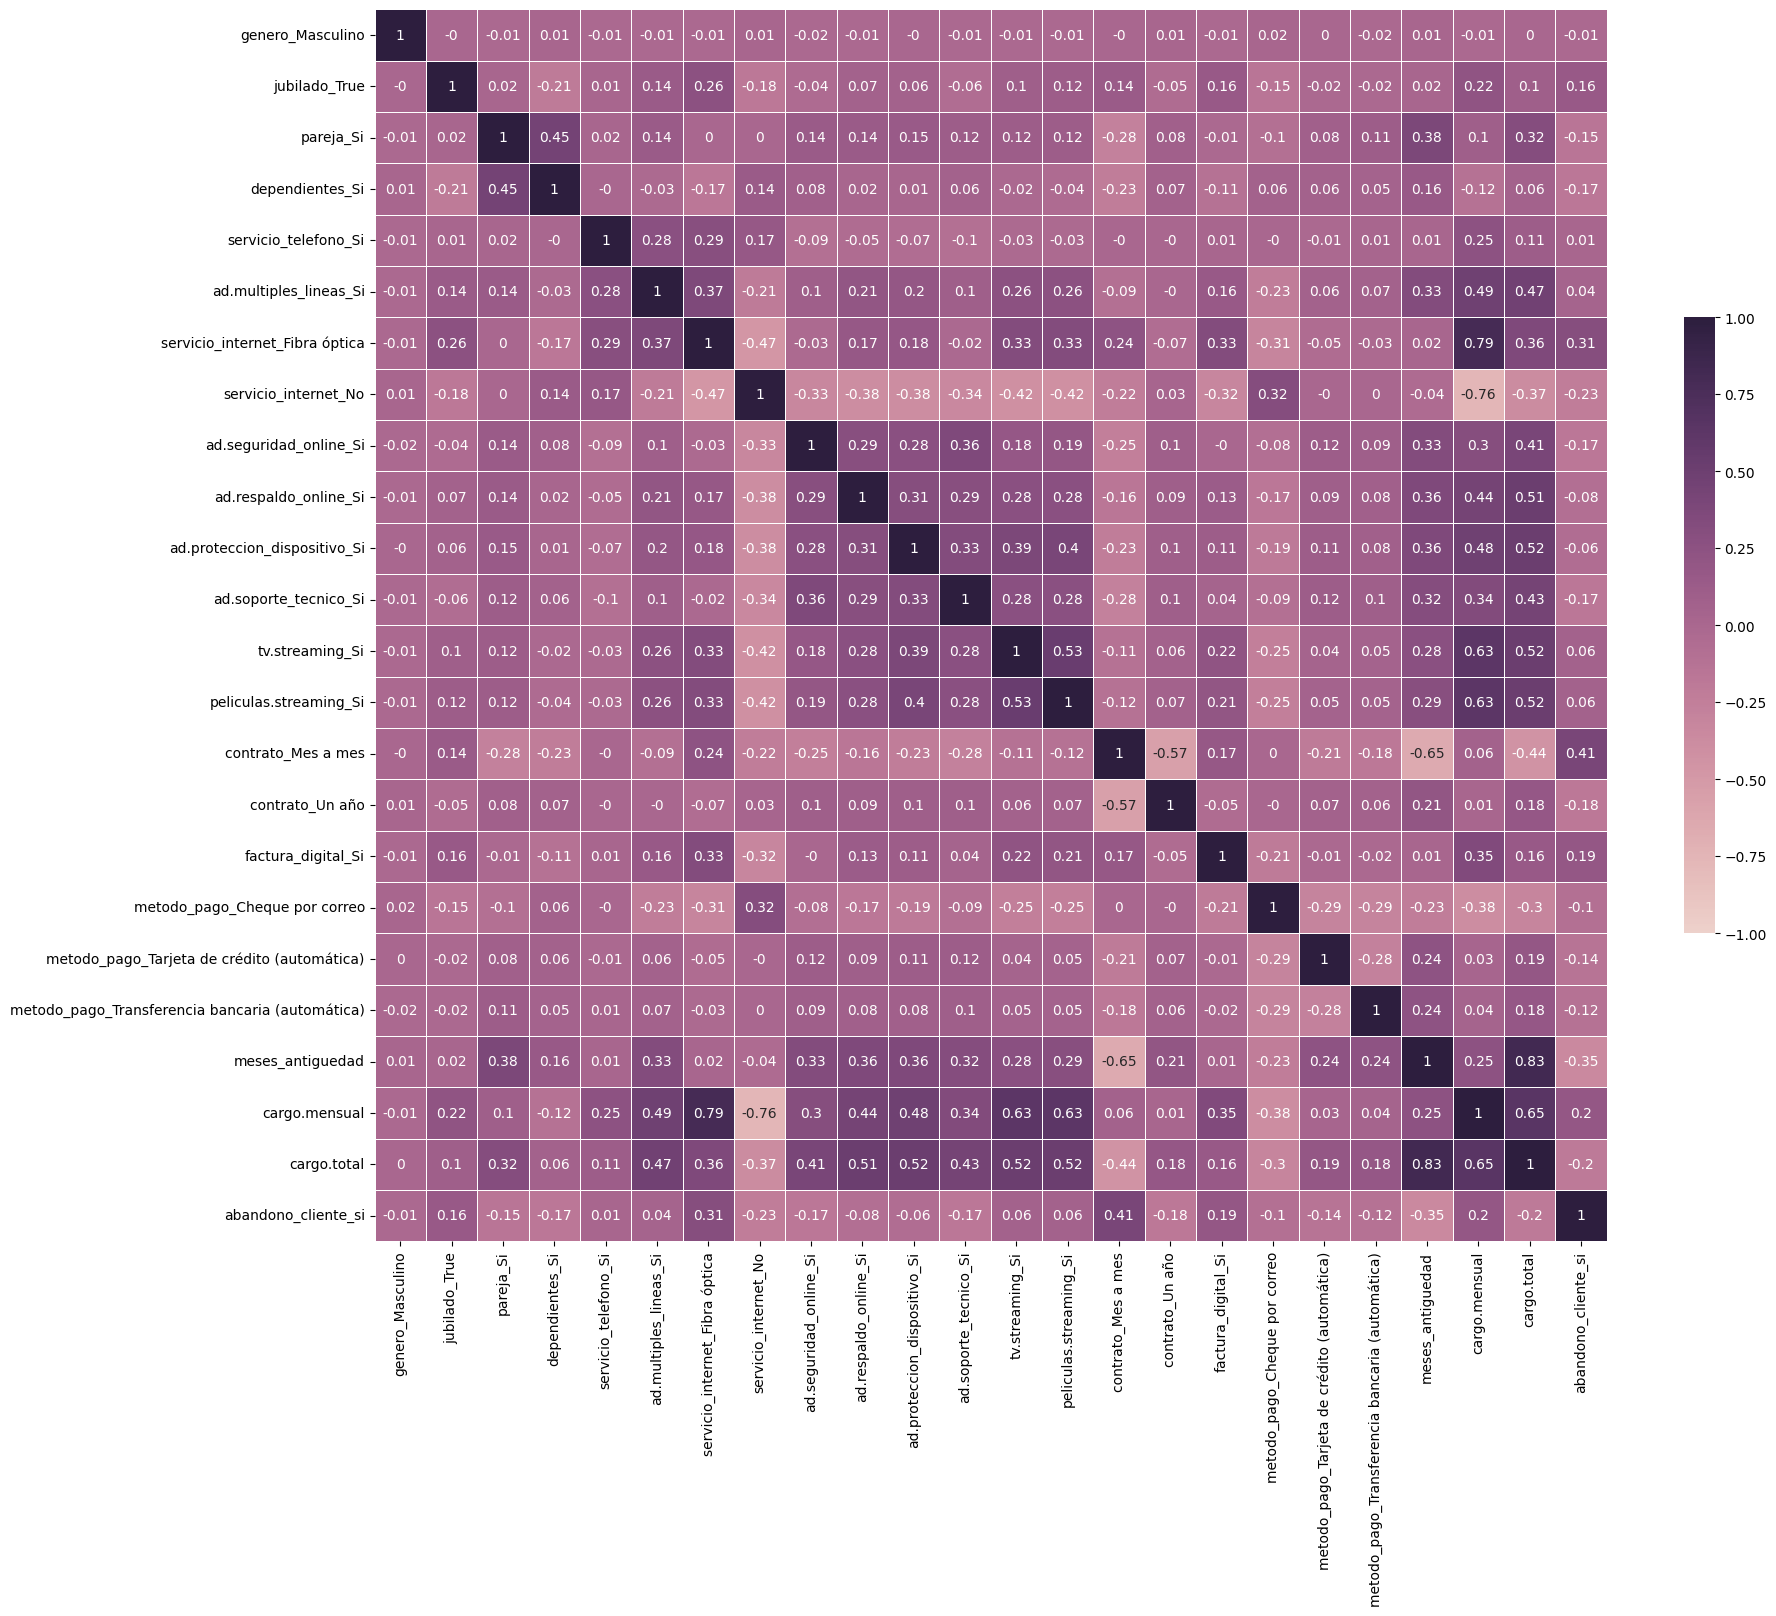

In [ ]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0, cmap=sns.cubehelix_palette(as_cmap=True),
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()

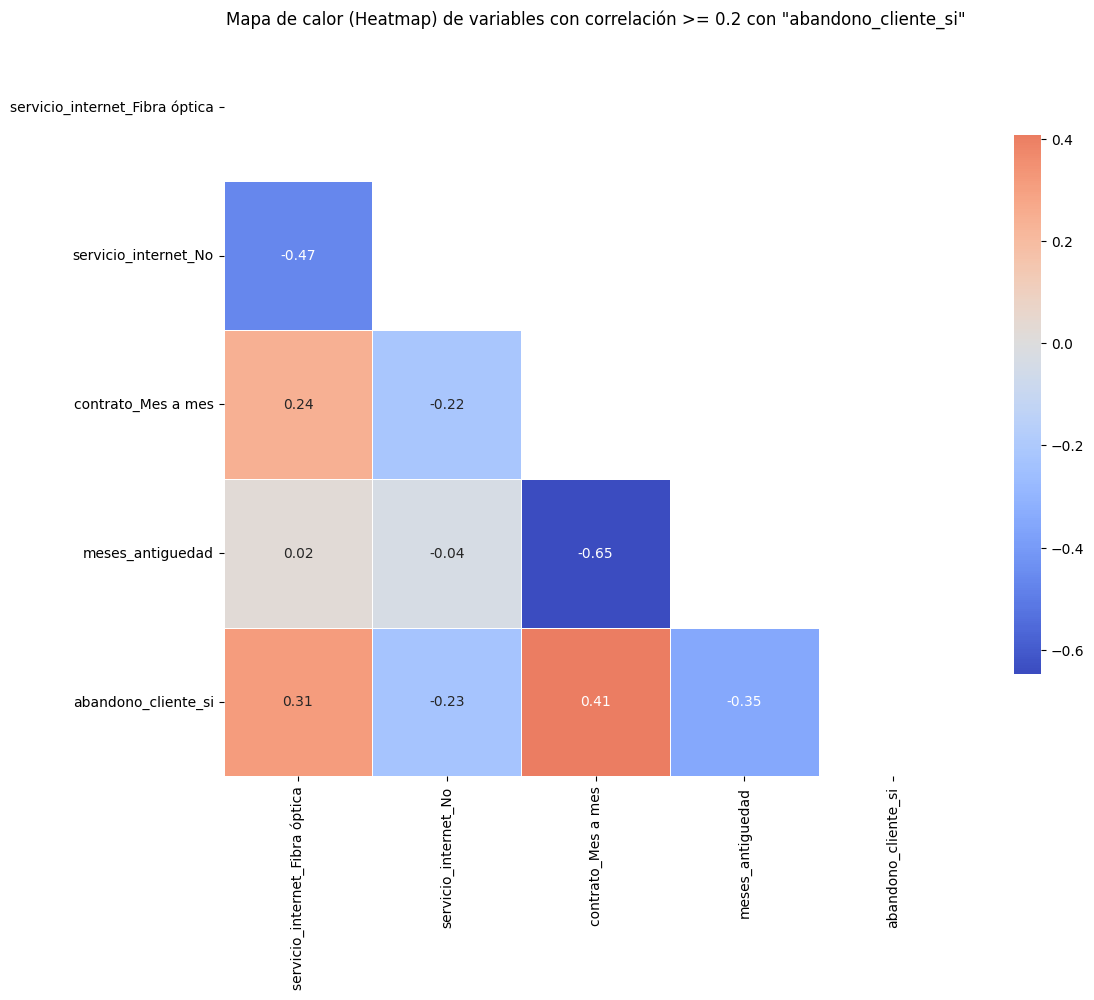

In [ ]:
# Definir la variable objetivo
target_var = 'abandono_cliente_si'

# Definir el umbral mínimo de correlación absoluta para selección
limite = 0.2

# Filtrar variables que tengan correlación absoluta >= umbral con la variable objetivo
# Esto crea una lista con las variables relevantes
variables_relevantes = corr.index[abs(corr[target_var]) >= limite].tolist()

# Asegurar que la variable objetivo esté en la lista (si no está, añadirla)
if target_var not in variables_relevantes:
    variables_relevantes.append(target_var)

# Crear una matriz de correlación solo con las variables seleccionadas
corr_filtrada = corr.loc[variables_relevantes, variables_relevantes]

# Generar una filtro para ocultar el triángulo superior de la matriz (incluida la diagonal)
filtro = np.triu(np.ones_like(corr_filtrada, dtype=bool))

# Graficar el Mapa de calor (heatmap) con la filtro aplicada para mejor visualización
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_filtrada,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    mask=filtro
)
plt.title(f'Mapa de calor (Heatmap) de variables con correlación >= {limite} con "{target_var}"')
plt.show()

#### Análisis de Multicolinealidad

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [ ]:
# Aquí, no incluyas la variable objetivo (ej: Churn\_Yes) en el cálculo del VIF.
X = Df_Encoded.drop(columns=['abandono_cliente_si'])

In [ ]:
X_const = add_constant(X)

In [ ]:
# Convert boolean columns to integers (0 or 1)
X_const = X_const.astype(float)

# Calcular el VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Mostrar resultado
display(vif_data.sort_values(by='VIF', ascending=False))

,feature,VIF
22,cargo.mensual,871.464258
0,const,646.049558
7,servicio_internet_Fibra óptica,149.020441
8,servicio_internet_No,105.056440
5,servicio_telefono_Si,35.174704
14,peliculas.streaming_Si,24.203807
13,tv.streaming_Si,24.123237
23,cargo.total,10.815154
21,meses_antiguedad,7.524785
6,ad.multiples_lineas_Si,7.302265


In [ ]:
import statsmodels.api as sm

# ====== Etapa 1: Copiar X original para não modificar o original ======
X_filtered = X_const.copy()

# ====== Etapa 2: Remover variáveis com multicolinearidade perfeita (VIF = inf) ======
cols_to_drop = [
    "servicio_telefono_Si",               # Altamente colinear com "MultipleLines"
    "ad.multiples_lineas_Si"  # Redundante com ausência de telefone
]
X_filtered.drop(columns=cols_to_drop, inplace=True)

# ====== Etapa 4: Remover redundância entre dummies da mesma variável categórica ======
# Se usou get_dummies sem drop_first, você tem dummies redundantes para InternetService
X_filtered.drop(columns=["servicio_internet_No"], inplace=True)

# ====== Etapa 5: Garantir que os dados estão em float para o VIF funcionar ======
X_filtered = X_filtered.astype(float)

# ====== Etapa 6: Recalcular o VIF ======
vif_data = pd.DataFrame()
vif_data["feature"] = X_filtered.columns
vif_data["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# ====== Etapa 7: Exibir os resultados ======
display(vif_data.sort_values(by="VIF", ascending=False))

,feature,VIF
0,const,42.922698
19,cargo.mensual,15.409641
20,cargo.total,10.607171
18,meses_antiguedad,7.456416
5,servicio_internet_Fibra óptica,6.536073
12,contrato_Mes a mes,3.390871
11,peliculas.streaming_Si,2.098428
10,tv.streaming_Si,2.097238
15,metodo_pago_Cheque por correo,1.699543
13,contrato_Un año,1.680108


In [ ]:
# === Eliminar la variable account.Charges.Total ===
X_final = X_filtered.drop(columns=["cargo.total"])

# === Recalcular el VIF ===
vif_data_final = pd.DataFrame()
vif_data_final["feature"] = X_final.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]

# === Mostrar los resultados ordenados ===
display(vif_data_final.sort_values(by="VIF", ascending=False))


,feature,VIF
0,const,33.272609
19,cargo.mensual,14.187726
5,servicio_internet_Fibra óptica,6.501774
12,contrato_Mes a mes,3.379201
18,meses_antiguedad,2.631113
10,tv.streaming_Si,2.082334
11,peliculas.streaming_Si,2.081997
13,contrato_Un año,1.669987
15,metodo_pago_Cheque por correo,1.657856
9,ad.soporte_tecnico_Si,1.636988


## 🤖 Modelado Predictivo



### Separación de Datos

Crea al menos dos modelos diferentes para predecir la cancelación de clientes.

- Un modelo puede requerir normalización, como **Regresión Logística** o **KNN**.
- El otro modelo puede no requerir normalización, como **Árbol de Decisión** o **Random Forest**.

💡 La decisión de aplicar o no la normalización depende de los modelos seleccionados. Ambos modelos pueden ser creados sin normalización, pero también es una opción combinar modelos con y sin normalización.

**Justificación:**

- **Regresión Logística / KNN:** Estos modelos son sensibles a la escala de los datos, por lo que la normalización es importante para que los coeficientes o las distancias se calculen correctamente.
- **Árbol de Decisión / Random Forest:** Estos modelos no dependen de la escala de los datos, por lo que no es necesario aplicar normalización.

Si decides normalizar los datos, deberías explicar cómo esta etapa asegura que los modelos basados en distancia o en optimización de parámetros no se vean sesgados por la magnitud de las variables.

### Normalización o Estandarización (si es necesario)

Evalúa la necesidad de normalizar o estandarizar los datos, según los modelos que se aplicarán. Modelos basados en distancia, como **KNN**, **SVM**, **Regresión Logística** y **Redes Neuronales**, requieren este preprocesamiento. Por otro lado, modelos basados en árboles, como **Decision Tree**, **Random Forest** y **XGBoost**, no son sensibles a la escala de los datos.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

### Balanceo de Clases (opcional)

Si deseas profundizar en el análisis, aplica técnicas de balanceo como **undersampling** o **oversampling**. En situaciones de fuerte desbalanceo, herramientas como **SMOTE** pueden ser útiles para generar ejemplos sintéticos de la clase minoritaria.

Utilizamos (SMOTE)

In [ ]:
# Aplicar SMOTE solo al conjunto de entrenamiento
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)

print("\nDistribución después de balanceo:")
print(pd.Series(y_train_bal).value_counts())


Distribución después de balanceo:
abandono_cliente
0    3737
1    3737
Name: count, dtype: int64


### Creación de Modelos

Crea al menos dos modelos diferentes para predecir la cancelación de clientes.

- Un modelo puede requerir normalización, como **Regresión Logística** o **KNN**.
- El otro modelo puede no requerir normalización, como **Árbol de Decisión** o **Random Forest**.

💡 La decisión de aplicar o no la normalización depende de los modelos seleccionados. Ambos modelos pueden ser creados sin normalización, pero también es una opción combinar modelos con y sin normalización.

**Justificación:**

- **Regresión Logística / KNN:** Estos modelos son sensibles a la escala de los datos, por lo que la normalización es importante para que los coeficientes o las distancias se calculen correctamente.
- **Árbol de Decisión / Random Forest:** Estos modelos no dependen de la escala de los datos, por lo que no es necesario aplicar normalización.

Si decides normalizar los datos, deberías explicar cómo esta etapa asegura que los modelos basados en distancia o en optimización de parámetros no se vean sesgados por la magnitud de las variables.

### Evaluación de los Modelos

Evalúa cada modelo utilizando las siguientes métricas:

- **Exactitud (Acurácia)**
- **Precisión**
- **Recall**
- **F1-score**
- **Matriz de confusión**

Después, realiza un análisis crítico y compara los modelos:

- ¿Cuál modelo tuvo el mejor desempeño?
- ¿Algún modelo presentó **overfitting** o **underfitting**? Si es así, considera las posibles causas y ajustes:
  - **Overfitting**: Cuando el modelo aprende demasiado sobre los datos de entrenamiento, perdiendo la capacidad de generalizar a nuevos datos. Considera reducir la complejidad del modelo o aumentar los datos de entrenamiento.
  - **Underfitting**: Cuando el modelo no captura bien las tendencias de los datos, lo que indica que es demasiado simple. Intenta aumentar la complejidad del modelo o ajustar sus parámetros.

### Modelado y Evaluación

In [ ]:
# Entrenar modelo con datos balanceados
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_bal, y_train_bal)

# Evaluar con test set original (sin balancear)
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1602
           1       0.56      0.58      0.57       579

    accuracy                           0.77      2181
   macro avg       0.70      0.71      0.70      2181
weighted avg       0.77      0.77      0.77      2181


AUC-ROC: 0.8238


## 🎯 Correlación y Selección de Variables



### Análisis Dirigido

Investiga cómo variables específicas se relacionan con la cancelación, tales como:

- **Tiempo de contrato × Cancelación**
- **Gasto total × Cancelación**

Utiliza gráficos como **boxplots** o **scatter plots** para visualizar patrones y posibles tendencias.

### Análisis de Correlación (Post-balanceo)

## 📋 Interpretación y Conclusiones Datos



### Análisis de la Importancia de las Variables

Después de elegir los modelos, realiza el análisis de las variables más relevantes para la predicción de la cancelación:

* Regresión Logística: Investiga los coeficientes de las variables, que muestran su contribución a la predicción de cancelación.

* KNN (K-Nearest Neighbors): Observa cómo los vecinos más cercanos influyen en la decisión de clasificación. Las variables más impactantes pueden ser aquellas que más contribuyen a la proximidad entre los puntos de datos.

* Random Forest: Utiliza la importancia de las variables proporcionada por el modelo. Random Forest calcula la importancia basándose en cómo cada variable contribuye a la reducción de la impureza durante las divisiones de los árboles.

* SVM (Support Vector Machine): En el SVM, las variables más relevantes son aquellas que influyen en la frontera de decisión entre las clases. Puedes analizar los coeficientes de los vectores de soporte para entender qué variables tienen mayor impacto.

* Otros Modelos: Dependiendo del modelo elegido, considera el análisis de métricas específicas para comprender la relevancia de las variables. Por ejemplo, coeficientes en modelos lineales, pesos en redes neuronales, o la importancia relativa en técnicas de boosting (como XGBoost).

### Conclusión

Elaboren un informe detallado, destacando los factores que más influyen en la cancelación, basándose en las variables seleccionadas y en el rendimiento de cada modelo.

Identifiquen los principales factores que afectan la cancelación de clientes y propongan estrategias de retención basadas en los resultados obtenidos.